In [1]:
import os
import requests
from duckduckgo_search import DDGS

In [2]:
# 定义豹子种类和对应的搜索关键词
leopard_types = {
    "African Leopard": "African Leopard",  # 非洲豹
    "Snow Leopard": "Snow Leopard",       # 雪豹
    "Jaguar": "Jaguar",                   # 美洲豹
    "Clouded Leopard": "Clouded Leopard", # 云豹
    "Amur Leopard": "Amur Leopard"        # 金钱豹
}

In [ ]:
# 设置每种豹子下载的图像数量
num_images_per_type = 50  # 可以根据需要调整，例如 50 或 200

# 创建保存图像的主目录
save_dir = "leopard_images"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 定义下载图像的函数
def download_images(query, num_images, save_folder):
    """
    从 DuckDuckGo 下载指定数量的图像并保存到指定文件夹。
    
    参数：
    - query: 搜索关键词（如 "African Leopard"）
    - num_images: 下载的图像数量
    - save_folder: 图像保存的文件夹路径
    """
    # 初始化 DuckDuckGo 搜索
    ddgs = DDGS()
    # 获取搜索结果
    results = ddgs.images(keywords=query, max_results=num_images)
    
    # 遍历搜索结果并下载图像
    for i, result in enumerate(results):
        image_url = result['image']  # 获取图像 URL
        try:
            # 发送 HTTP 请求下载图像
            response = requests.get(image_url, timeout=10)
            if response.status_code == 200:
                # 生成保存路径，文件名格式如 "African_Leopard_1.jpg"
                image_path = os.path.join(save_folder, f"{query.replace(' ', '_')}_{i+1}.jpg")
                # 保存图像
                with open(image_path, 'wb') as f:
                    f.write(response.content)
                print(f"已下载: {image_path}")
            else:
                print(f"下载失败: {image_url} (状态码: {response.status_code})")
        except Exception as e:
            print(f"下载 {image_url} 时出错: {e}")

# 为每种豹子下载图像
for leopard, query in leopard_types.items():
    print(f"正在下载 {leopard} 的图像...")
    # 创建每种豹子的子文件夹
    leopard_folder = os.path.join(save_dir, leopard.replace(' ', '_'))
    if not os.path.exists(leopard_folder):
        os.makedirs(leopard_folder)
    # 调用下载函数
    download_images(query, num_images_per_type, leopard_folder)

print("所有图像下载完成！")

In [3]:
from PIL import Image

# 定义图像保存的主目录（与下载代码中的目录一致）
save_dir = "leopard_images"

# 定义检查并删除损坏图片的函数
def remove_corrupted_images(directory):
    """
    检查目录中的图片，删除无法打开或损坏的图片。
    
    参数：
    - directory: 图像保存的根目录
    """
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # 尝试打开图片并验证其完整性
                img = Image.open(file_path)
                img.verify()  # 检查图片是否损坏
            except (IOError, SyntaxError) as e:
                # 如果图片损坏，删除它
                print(f"发现损坏图片，已删除: {file_path}")
                os.remove(file_path)

# 调用函数清理损坏图片
remove_corrupted_images(save_dir)
print("所有损坏图片已清理完成！")


所有损坏图片已清理完成！


In [5]:
import os
import random
import shutil

# 定义目录
input_folder = "leopard_images"
output_folder = "leopard_dataset"
os.makedirs(output_folder, exist_ok=True)

# 创建子目录
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_folder, split), exist_ok=True)

# 遍历每种豹子
for leopard in os.listdir(input_folder):
    leopard_path = os.path.join(input_folder, leopard)
    if os.path.isdir(leopard_path):
        images = os.listdir(leopard_path)
        random.shuffle(images)  # 随机打乱图片顺序
        total_images = len(images)
        
        # 计算划分点
        train_end = int(0.7 * total_images)  # 70% 训练集
        val_end = train_end + int(0.15 * total_images)  # 15% 验证集
        
        # 划分图片
        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]
        
        # 为每种豹子创建子文件夹并复制图片
        for split, img_list in [("train", train_images), ("val", val_images), ("test", test_images)]:
            split_folder = os.path.join(output_folder, split, leopard)
            os.makedirs(split_folder, exist_ok=True)
            for img in img_list:
                shutil.copy(os.path.join(leopard_path, img), os.path.join(split_folder, img))

print("数据集划分完成！")

数据集划分完成！


In [6]:
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader

# 定义图像转换（改进你的原始代码）
transform_img = T.Compose([
    T.Resize((224, 224)),           # 调整图像大小到 224x224
    T.ToTensor(),                   # 转换为张量，像素值缩放到 [0, 1]
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 加载数据集
train_dataset = datasets.ImageFolder(root='leopard_dataset/train', transform=transform_img)
val_dataset = datasets.ImageFolder(root='leopard_dataset/val', transform=transform_img)
test_dataset = datasets.ImageFolder(root='leopard_dataset/test', transform=transform_img)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 检查类别
print(train_dataset.classes)  # 输出类别名称，例如 ['African_Leopard', 'Snow_Leopard', ...]

['African_Leopard', 'Amur_Leopard', 'Clouded_Leopard', 'Jaguar', 'Snow_Leopard']


In [7]:
# 1. 查看基本属性
print("train_loader 对象:", train_loader)
print("Batch size:", train_loader.batch_size)
# print("Shuffle:", train_loader.shuffle)
print("总批次数:", len(train_loader))
print("类别名称:", train_loader.dataset.classes)

# 2. 查看一个批次的数据
images, labels = next(iter(train_loader))  # 获取第一个批次
print("\nImages shape:", images.shape)    # 例如: torch.Size([32, 3, 224, 224])
print("Labels shape:", labels.shape)      # 例如: torch.Size([32])
print("Labels:", labels)                  # 打印具体标签值，例如 tensor([0, 1, 2, ...])

# 3. （可选）查看第一张图像的张量值
print("\n第一张图像的部分张量值:", images[0, :, :5, :5])  # 显示前 5x5 像素


train_loader 对象: <torch.utils.data.dataloader.DataLoader object at 0x0000021C030A55B0>
Batch size: 32
总批次数: 5
类别名称: ['African_Leopard', 'Amur_Leopard', 'Clouded_Leopard', 'Jaguar', 'Snow_Leopard']

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Labels: tensor([1, 1, 1, 3, 1, 2, 3, 1, 4, 3, 0, 4, 2, 4, 3, 3, 0, 4, 4, 0, 1, 2, 0, 0,
        0, 3, 4, 4, 2, 2, 3, 2])

第一张图像的部分张量值: tensor([[[-1.2788, -1.1932, -1.0562, -0.9877, -0.8678],
         [-1.2788, -1.1589, -0.9877, -0.9363, -0.8849],
         [-1.3130, -1.1075, -1.0219, -1.0390, -0.8335],
         [-1.4500, -1.2274, -1.1075, -1.1589, -0.8849],
         [-1.5185, -1.3473, -1.1932, -1.1589, -1.0733]],

        [[-0.4601, -0.3725, -0.2850, -0.2675, -0.0924],
         [-0.4601, -0.3375, -0.3025, -0.2500, -0.1099],
         [-0.5301, -0.3550, -0.3725, -0.3550, -0.1099],
         [-0.6352, -0.4601, -0.4251, -0.4426, -0.1275],
         [-0.7402, -0.6527, -0.5126, -0.4426, -0.2850]],

        [[-1.1073, -1.0724, 

In [8]:
import torch.nn as nn

# 定义模型（假设已有）
class Net(nn.Module):
    def __init__(self, num_classes=5):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.dropout = nn.Dropout2d(p=0.1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# 实例化模型
net = Net(num_classes=5)
print(net)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=5, bias=True)
)


In [9]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy

# 定义一个日志打印函数，用于在训练过程中输出时间戳和信息，便于调试和监控。
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

class StepRunner:
    def __init__(self, net, loss_fn, stage="train", metrics_dict=None, optimizer=None):
        self.net, self.loss_fn, self.metrics_dict, self.stage = net, loss_fn, metrics_dict, stage
        self.optimizer = optimizer

    def step(self, features, labels):
        # 前向传播，计算预测值
        preds = self.net(features)
        # 计算损失
        loss = self.loss_fn(preds, labels)

        # 如果是训练阶段，进行反向传播和优化
        if self.optimizer is not None and self.stage == "train":
            loss.backward()  # 反向传播
            self.optimizer.step()  # 更新参数
            self.optimizer.zero_grad()  # 清空梯度

        # 计算指标
        step_metrics = {
            self.stage + "_" + name: metric_fn(preds, labels).item()
            for name, metric_fn in self.metrics_dict.items()
        }
        return loss.item(), step_metrics

    def train_step(self, features, labels):
        self.net.train()  # 设置为训练模式，dropout 层生效
        return self.step(features, labels)

    @torch.no_grad()
    def eval_step(self, features, labels):
        self.net.eval()  # 设置为评估模式，dropout 层不生效
        return self.step(features, labels)

    def __call__(self, features, labels):
        if self.stage == "train":
            return self.train_step(features, labels)
        else:
            return self.eval_step(features, labels)

        
class EpochRunner:
    def __init__(self, steprunner):
        self.steprunner = steprunner
        self.stage = steprunner.stage

    def __call__(self, dataloader):
        total_loss, step = 0, 0
        loop = tqdm(enumerate(dataloader), total=len(dataloader), file=sys.stdout)
        for i, batch in loop:
            # 执行单步训练或评估
            loss, step_metrics = self.steprunner(*batch)
            # 记录损失和指标
            step_log = dict({self.stage + "_loss": loss}, **step_metrics)
            total_loss += loss
            step += 1
            # 更新进度条
            if i != len(dataloader) - 1:
                loop.set_postfix(**step_log)
            else:
                # 计算 epoch 的平均损失和指标
                epoch_loss = total_loss / step
                epoch_metrics = {
                    self.stage + "_" + name: metric_fn.compute().item()
                    for name, metric_fn in self.steprunner.metrics_dict.items()
                }
                epoch_log = dict({self.stage + "_loss": epoch_loss}, **epoch_metrics)
                loop.set_postfix(**epoch_log)
                # 重置指标计算器
                for name, metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log



def train_model(net, optimizer, loss_fn, metrics_dict, train_data, val_data=None, epochs=10, ckpt_path='checkpoint.pt', patience=5, monitor="val_loss", mode="min"):
    history = {}

    for epoch in range(1, epochs + 1):
        printlog("Epoch {0} / {1}".format(epoch, epochs))

        # 1. 训练阶段
        train_step_runner = StepRunner(net=net, stage="train", loss_fn=loss_fn, metrics_dict=deepcopy(metrics_dict), optimizer=optimizer)
        train_epoch_runner = EpochRunner(train_step_runner)
        train_metrics = train_epoch_runner(train_data)
        for name, metric in train_metrics.items():
            history[name] = history.get(name, []) + [metric]

        # 2. 验证阶段
        if val_data:
            val_step_runner = StepRunner(net=net, stage="val", loss_fn=loss_fn, metrics_dict=deepcopy(metrics_dict))
            val_epoch_runner = EpochRunner(val_step_runner)
            with torch.no_grad():
                val_metrics = val_epoch_runner(val_data)
            val_metrics["epoch"] = epoch
            for name, metric in val_metrics.items():
                history[name] = history.get(name, []) + [metric]

        # 3. 早停机制
        arr_scores = history[monitor]
        best_score_idx = np.argmax(arr_scores) if mode == "max" else np.argmin(arr_scores)
        if best_score_idx == len(arr_scores) - 1:
            torch.save(net.state_dict(), ckpt_path)
            print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor, arr_scores[best_score_idx]), file=sys.stderr)
        if len(arr_scores) - best_score_idx > patience:
            print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(monitor, patience), file=sys.stderr)
            break
        net.load_state_dict(torch.load(ckpt_path, weights_only=True))

    return pd.DataFrame(history)


模型已经准备好了，下一步需要设备管理，如果有GPU，可以移动到GPU加速计算

然后定义损失函数、优化器、指标字典

In [10]:
import torchmetrics
from torch.optim import Adam
from torchmetrics import Accuracy

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
print("使用设备：", device)

# 定义损失函数（多类别分类）
loss_fn = nn.CrossEntropyLoss()

# 定义优化器
optimizer = Adam(net.parameters(), lr=0.003)  # 学习率调整为 0.001，避免过高

# 定义指标（多类别分类）
metrics_dict = {"acc": Accuracy(task='multiclass', num_classes=5).to(device)}


使用设备： cpu


In [11]:
train_data = train_loader
val_data = val_loader

In [12]:
# 调用 train_model 函数进行训练
dfhistory = train_model(
    net,
    optimizer,
    loss_fn,
    metrics_dict,
    train_data=train_data,
    val_data=val_data,
    epochs=50,
    patience=10,
    monitor="val_acc",
    mode="max"
)



================================================================================2025-03-14 17:20:53
Epoch 1 / 50

100%|██████████| 1/1 [00:01<00:00,  1.11s/it, val_acc=0.133, val_loss=1.52]

<<<<<< reach best val_acc : 0.13333334028720856 >>>>>>




================================================================================2025-03-14 17:21:02
Epoch 2 / 50

100%|██████████| 1/1 [00:01<00:00,  1.03s/it, val_acc=0.433, val_loss=1.54]

<<<<<< reach best val_acc : 0.4333333373069763 >>>>>>




================================================================================2025-03-14 17:21:12
Epoch 3 / 50

100%|██████████| 1/1 [00:01<00:00,  1.12s/it, val_acc=0.3, val_loss=1.46]

================================================================================2025-03-14 17:21:22
Epoch 4 / 50

100%|██████████| 1/1 [00:01<00:00,  1.05s/it, val_acc=0.233, val_loss=1.48]

================================================================================2025-03-14 17:21:31
Epoch 5 / 50

100%|██████████| 1/1 [00:01<00:00,  1.05s/it, val_acc=0.333, val_loss=1.48]

================================================================================2025-03-14 17:21:41
Epoch 6 / 50

100%|██████████| 1/1 [00:01<00:00,  1.00s/it, val_acc=0.3, val_loss=1.48]

================================================================================2025-03-14 17:21:50
Epoch 7 / 50

100%|██████████| 1/1 [00:01<00:00,  1.06s/it, val_acc=0.3, val_loss=1.46]

=================================================

<<<<<< val_acc without improvement in 10 epoch, early stopping >>>>>>


In [13]:
import torchvision.transforms as T

transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    T.RandomRotation(15),           # 随机旋转 ±15 度
    T.ColorJitter(brightness=0.2, contrast=0.2),  # 调整亮度和对比度
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [14]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder('leopard_dataset/train', transform=transform_train)
val_dataset = datasets.ImageFolder('leopard_dataset/val', transform=transform_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [15]:
import torch.nn as nn

class ImprovedNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ImprovedNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # 提高 dropout 概率
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

net = ImprovedNet(num_classes=5)


In [16]:
from torchvision import datasets, transforms as T, models

# 使用预训练模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 5)
net.to(device)

d:\Program\Miniforge3\envs\fast\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Program\Miniforge3\envs\fast\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
from torch.optim.lr_scheduler import StepLR

# 损失函数、优化器和指标
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
metrics_dict = {"acc": Accuracy(task='multiclass', num_classes=5).to(device)}

In [ ]:
import os
import sys
import time
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import Dict, Any, Optional, Union, Callable

import torch
from torch import nn
from torch.utils.data import DataLoader
from copy import deepcopy


def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

class MetricTracker:
    """指标跟踪器，用于统一管理各种评估指标的计算"""
    
    def __init__(self, metrics_dict):
        """
        Args:
            metrics_dict: 包含指标名称和计算函数的字典
        """
        self.metrics_dict = metrics_dict
        self.running_metrics = {}
        self.sample_count = 0
        
    def update(self, preds, labels):
        """更新指标值
        
        Args:
            preds: 模型预测值
            labels: 真实标签
        
        Returns:
            Dict: 当前批次的指标值
        """
        batch_metrics = {}
        for name, metric_fn in self.metrics_dict.items():
            value = metric_fn(preds, labels).item()
            batch_metrics[name] = value
            
            # 累积计算平均值
            if name not in self.running_metrics:
                self.running_metrics[name] = 0.0
            self.running_metrics[name] += value * len(labels)
            
        self.sample_count += len(labels)
        return batch_metrics
    
    def compute(self):
        """计算累积后的平均指标值
        
        Returns:
            Dict: 平均指标值
        """
        if self.sample_count == 0:
            return {name: 0.0 for name in self.metrics_dict.keys()}
        
        return {name: value / self.sample_count 
                for name, value in self.running_metrics.items()}
    
    def reset(self):
        """重置所有累积的指标值"""
        self.running_metrics = {}
        self.sample_count = 0


class StepRunner:
    """单步训练/评估运行器"""
    
    def __init__(self, net, loss_fn, stage="train", metrics_dict=None, 
                 optimizer=None, device=None, use_amp=False):
        """
        Args:
            net: 神经网络模型
            loss_fn: 损失函数
            stage: 阶段，'train'或'val'
            metrics_dict: 评估指标字典
            optimizer: 优化器（仅在训练时需要）
            device: 运行设备
            use_amp: 是否使用混合精度训练
        """
        self.net = net
        self.loss_fn = loss_fn
        self.stage = stage
        self.metrics = MetricTracker(metrics_dict or {})
        self.optimizer = optimizer
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.use_amp = use_amp and torch.cuda.is_available()
        self.scaler = torch.cuda.amp.GradScaler() if self.use_amp else None
        
    def step(self, features, labels):
        """执行一步训练或评估
        
        Args:
            features: 输入特征
            labels: 目标标签
            
        Returns:
            Tuple: (损失值, 指标字典)
        """
        # 将数据移动到指定设备
        if isinstance(features, torch.Tensor):
            features = features.to(self.device)
        if isinstance(labels, torch.Tensor):
            labels = labels.to(self.device)
            
        # 使用自动混合精度
        if self.use_amp and self.stage == "train":
            with torch.cuda.amp.autocast():
                preds = self.net(features)
                loss = self.loss_fn(preds, labels)
                
            # 训练阶段：反向传播和优化
            if self.optimizer is not None:
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
        else:
            # 常规前向传播
            preds = self.net(features)
            loss = self.loss_fn(preds, labels)
            
            # 训练阶段：反向传播和优化
            if self.optimizer is not None and self.stage == "train":
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

        # 计算批次指标
        batch_metrics = self.metrics.update(preds, labels)
        step_metrics = {f"{self.stage}_{name}": value for name, value in batch_metrics.items()}
        
        return loss.item(), step_metrics

    def train_step(self, features, labels):
        """执行一步训练
        
        Args:
            features: 输入特征
            labels: 目标标签
            
        Returns:
            Tuple: (损失值, 指标字典)
        """
        self.net.train()
        return self.step(features, labels)

    @torch.no_grad()
    def eval_step(self, features, labels):
        """执行一步评估
        
        Args:
            features: 输入特征
            labels: 目标标签
            
        Returns:
            Tuple: (损失值, 指标字典)
        """
        self.net.eval()
        return self.step(features, labels)

    def __call__(self, features, labels):
        """执行单步
        
        Args:
            features: 输入特征
            labels: 目标标签
            
        Returns:
            Tuple: (损失值, 指标字典)
        """
        if self.stage == "train":
            return self.train_step(features, labels)
        else:
            return self.eval_step(features, labels)


class EpochRunner:
    """整个epoch的训练/评估运行器"""
    
    def __init__(self, steprunner):
        """
        Args:
            steprunner: StepRunner实例
        """
        self.steprunner = steprunner
        self.stage = steprunner.stage

    def __call__(self, dataloader):
        """执行一个epoch的训练或评估
        
        Args:
            dataloader: 数据加载器
            
        Returns:
            Dict: 包含损失和指标的字典
        """
        total_loss, step = 0, 0
        # 创建进度条
        loop = tqdm(enumerate(dataloader), total=len(dataloader), file=sys.stdout)
        
        for i, batch in loop:
            # 执行单步训练或评估
            loss, step_metrics = self.steprunner(*batch)
            
            # 更新累积损失和步数
            total_loss += loss
            step += 1
            
            # 更新进度条
            if i != len(dataloader) - 1:
                loop.set_postfix(**step_metrics)
            else:
                # 计算整个epoch的平均指标
                epoch_loss = total_loss / step
                epoch_metrics = self.steprunner.metrics.compute()
                epoch_log = {
                    f"{self.stage}_loss": epoch_loss, 
                    **{f"{self.stage}_{name}": value for name, value in epoch_metrics.items()}
                }
                loop.set_postfix(**epoch_log)
                
                # 重置指标计算器
                self.steprunner.metrics.reset()
                
        return epoch_log


def train_model(
    net, 
    optimizer, 
    loss_fn, 
    metrics_dict, 
    train_data, 
    val_data=None, 
    epochs=10, 
    ckpt_path='checkpoint.pt', 
    patience=5, 
    monitor="val_loss", 
    mode="min",
    scheduler=None,
    device=None,
    use_amp=False
):
    """通用模型训练函数
    
    Args:
        net: 神经网络模型
        optimizer: 优化器
        loss_fn: 损失函数
        metrics_dict: 评估指标字典
        train_data: 训练数据加载器
        val_data: 验证数据加载器（可选）
        epochs: 训练轮数
        ckpt_path: 检查点保存路径
        patience: 早停耐心值
        monitor: 监控的指标名称
        mode: 监控模式，'min'或'max'
        scheduler: 学习率调度器（可选）
        device: 运行设备
        use_amp: 是否使用混合精度训练
        
    Returns:
        pd.DataFrame: 训练历史记录
    """
    # 确定设备
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    printlog(f"Training on device: {device}")
    net = net.to(device)
    
    # 初始化训练历史记录
    history = {}
    best_score = float('inf') if mode == "min" else float('-inf')
    counter = 0  # 早停计数器
    
    # 开始训练循环
    for epoch in range(1, epochs + 1):
        printlog(f"Epoch {epoch} / {epochs}")
        
        # 1. 训练阶段
        train_step_runner = StepRunner(
            net=net, 
            stage="train", 
            loss_fn=loss_fn, 
            metrics_dict=deepcopy(metrics_dict), 
            optimizer=optimizer,
            device=device,
            use_amp=use_amp
        )
        train_epoch_runner = EpochRunner(train_step_runner)
        train_metrics = train_epoch_runner(train_data)
        
        # 记录训练指标
        for name, metric in train_metrics.items():
            history[name] = history.get(name, []) + [metric]
        
        # 2. 验证阶段
        if val_data:
            val_step_runner = StepRunner(
                net=net, 
                stage="val", 
                loss_fn=loss_fn, 
                metrics_dict=deepcopy(metrics_dict),
                device=device
            )
            val_epoch_runner = EpochRunner(val_step_runner)
            with torch.no_grad():
                val_metrics = val_epoch_runner(val_data)
            
            # 记录验证指标
            val_metrics["epoch"] = epoch
            for name, metric in val_metrics.items():
                history[name] = history.get(name, []) + [metric]
            
            # 3. 早停机制
            current_score = val_metrics[monitor]
            improved = (mode == "min" and current_score < best_score) or \
                       (mode == "max" and current_score > best_score)
            
            if improved:
                best_score = current_score
                counter = 0
                # 保存最佳模型
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'score': best_score,
                }, ckpt_path)
                print(f"[INFO] ✓ New best {monitor}: {best_score:.4f} (Epoch {epoch})", file=sys.stderr)
            else:
                counter += 1
                print(f"[INFO] ! {monitor} did not improve from {best_score:.4f}", file=sys.stderr)
                
            if counter >= patience:
                print(f"[INFO] ⚠ Early stopping triggered after {patience} epochs without improvement", file=sys.stderr)
                break
        
        # 更新学习率
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) and val_data:
                scheduler.step(val_metrics[monitor])
            else:
                scheduler.step()
    
    # 加载最佳模型
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, weights_only=True)  # 添加weights_only=True参数
        net.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']} with {monitor}: {checkpoint['score']:.4f}")
    
    return pd.DataFrame(history)

In [19]:
# 添加学习率调度器
# scheduler = torch.optim.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# 使用带新功能的训练调用
dfhistory = train_model(
    net=net,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics_dict=metrics_dict,
    train_data=train_loader,
    val_data=val_loader,
    epochs=50,
    ckpt_path='best_model.pt',
    patience=10,
    monitor="val_acc",
    mode="max",
    # 新增可选参数
    scheduler=scheduler,                  # 学习率调度器
    # device=torch.device("cuda:0"),        # 指定GPU设备（可选）
    # use_amp=True                          # 启用混合精度训练加速
)


[2025-03-14 17:23:48] Training on device: cpu


[2025-03-14 17:23:48] Epoch 1 / 50

100%|██████████| 1/1 [00:01<00:00,  1.12s/it, val_acc=0.733, val_loss=0.973]

[INFO] ✓ New best val_acc: 0.7333 (Epoch 1)




[2025-03-14 17:24:01] Epoch 2 / 50

100%|██████████| 1/1 [00:01<00:00,  1.17s/it, val_acc=0.833, val_loss=0.694]


[INFO] ✓ New best val_acc: 0.8333 (Epoch 2)



[2025-03-14 17:24:14] Epoch 3 / 50

100%|██████████| 1/1 [00:01<00:00,  1.22s/it, val_acc=0.833, val_loss=0.642]

[INFO] ! val_acc did not improve from 0.8333




[2025-03-14 17:24:27] Epoch 4 / 50

100%|██████████| 1/1 [00:01<00:00,  1.13s/it, val_acc=0.8, val_loss=0.689]

[INFO] ! val_acc did not improve from 0.8333




[2025-03-14 17:24:40] Epoch 5 / 50

100%|██████████| 1/1 [00:01<00:00,  1.11s/it, val_acc=0.8, val_loss=0.676]

[INFO] ! val_acc did not improve from 0.8333




[2025-03-14 17:24:53] Epoch 6 / 50

100%|██████████| 1/1 [00:01<00:00,  1.18s/it, val_acc=0.8, val_loss=0.631]

[INFO] ! val_acc did not improve from 0.8333




[2025-03-14 17:25:06] Epoch 7 / 50

100%|██████████| 1/1 [00:01<00:00,  1.19s/it, val_acc=0.8, val_loss=0.618]

[INFO] ! val_acc did not improve from 0.8333




[2025-03-14 17:25:19] Epoch 8 / 50

100%|██████████| 1/1 [00:01<00:00,  1.14s/it, val_acc=0.8, val_loss=0.596]

[INFO] ! val_acc did not improve from 0.8333




[2025-03-14 17:25:31] Epoch 9 / 50

100%|██████████| 1/1 [00:01<00:00,  1.14s/it, val_acc=0.8, val_loss=0.606]

[INFO] ! val_acc did not improve from 0.8333




[2025-03-14 17:25:44] Epoch 10 / 50

100%|██████████| 1/1 [00:01<00:00,  1.21s/it, val_acc=0.8, val_loss=0.661]

[INFO] ! val_acc did not improve from 0.8333




[2025-03-14 17:25:57] Epoch 11 / 50

100%|██████████| 1/1 [00:01<00:00,  1.15s/it, val_acc=0.8, val_loss=0.639]

[INFO] ! val_acc did not improve from 0.8333




[2025-03-14 17:26:10] Epoch 12 / 50

100%|██████████| 1/1 [00:01<00:00,  1.21s/it, val_acc=0.8, val_loss=0.59]
Loaded best model from epoch 2 with val_acc: 0.8333


[INFO] ! val_acc did not improve from 0.8333
[INFO] ⚠ Early stopping triggered after 10 epochs without improvement


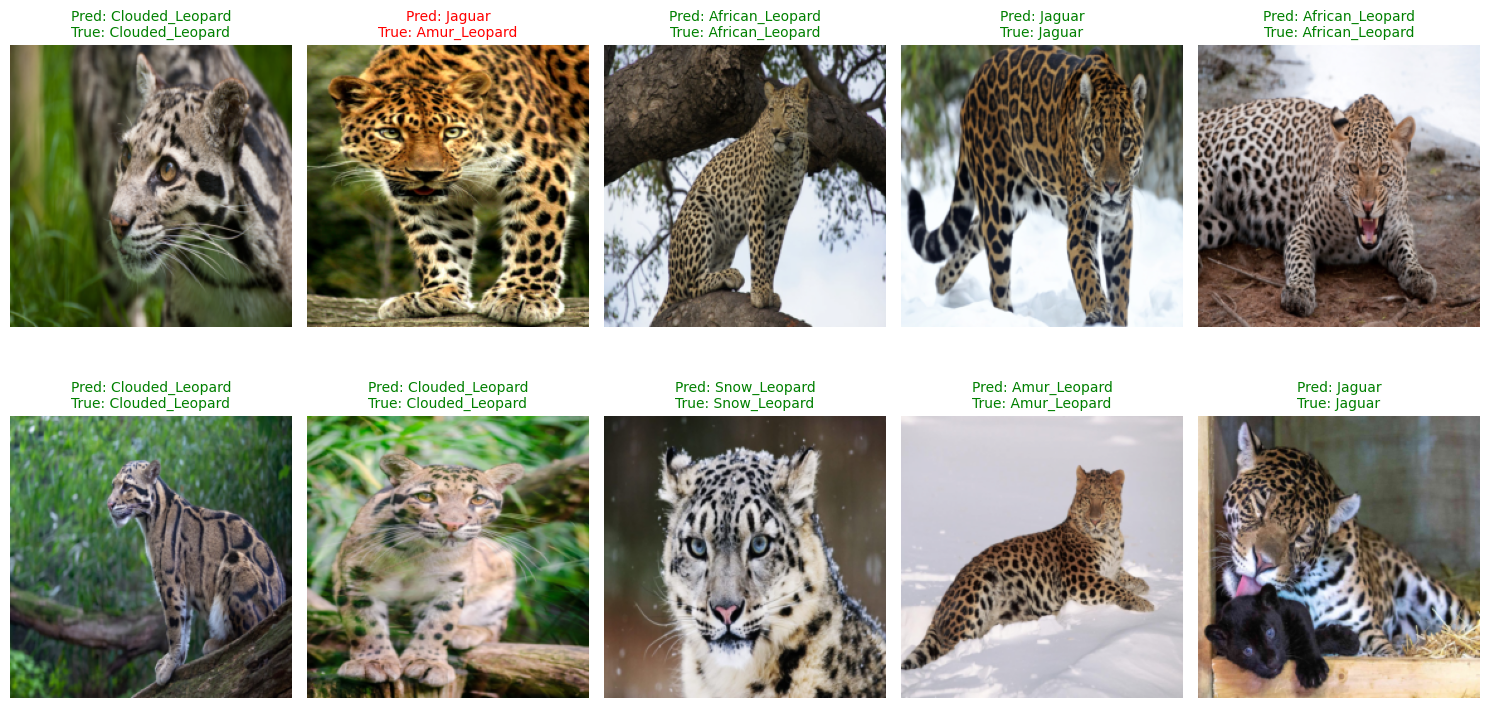

In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
from torchvision import models

# 定义图像预处理（与训练时一致）
transform_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载验证集（假设数据集路径为 'leopard_dataset/val'）
val_dataset = datasets.ImageFolder('leopard_dataset/val', transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 获取类别名称
class_names = val_dataset.classes  # 例如 ['african', 'snow', 'jaguar', 'clouded', 'leopard']

# 加载模型（假设使用 ResNet18）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = models.resnet18(pretrained=False)  # 不加载预训练权重，因为我们用自己的模型
net.fc = nn.Linear(net.fc.in_features, 5)  # 5 类豹子
checkpoint = torch.load('best_model.pt', weights_only=True)
net.load_state_dict(checkpoint['model_state_dict'])  # 提取模型权重
net.to(device)
net.eval()  # 设置为评估模式

# 随机选择 10 张图片进行预测
num_images = 10
indices = np.random.choice(len(val_dataset), num_images, replace=False)
images = []
true_labels = []
pred_labels = []

with torch.no_grad():
    for idx in indices:
        image, label = val_dataset[idx]
        images.append(image)
        true_labels.append(label)
        image = image.unsqueeze(0).to(device)  # 添加批次维度并移到设备
        output = net(image)
        pred = output.argmax(dim=1).item()  # 获取预测类别
        pred_labels.append(pred)

# 可视化
plt.figure(figsize=(15, 8))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)  # 2 行 5 列布局
    img = images[i].permute(1, 2, 0).cpu().numpy()  # 转换回 HWC 格式
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # 反归一化
    img = np.clip(img, 0, 1)  # 确保像素值在 [0, 1] 范围内
    plt.imshow(img)
    pred_label = class_names[pred_labels[i]]
    true_label = class_names[true_labels[i]]
    title_color = 'green' if pred_labels[i] == true_labels[i] else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=title_color, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

# 可选：保存图片到文件
# plt.savefig('leopard_classification_demo.png', dpi=300, bbox_inches='tight')


In [2]:
# 导入生成的脚本中的函数
from paper_plots import (generate_evaluation_plots, visualize_misclassified_samples, 
                         plot_grad_cam, plot_class_performance)

import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import pandas as pd

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载验证数据集
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载数据集
val_dataset = datasets.ImageFolder('leopard_dataset/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 获取类别名称
class_names = val_dataset.classes

# 加载模型
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(class_names))

# 加载模型权重
checkpoint = torch.load('best_model.pt', weights_only=True)
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)

# 设置输出目录
output_dir = 'paper_figures'

# 1. 生成评估图表
metrics = generate_evaluation_plots(
    model=model,
    val_loader=val_loader,
    class_names=class_names,
    # 如果你有训练历史可以加载:
    # history_df=pd.read_csv('training_history.csv'), 
    feature_layer_name='layer4',  # 对于ResNet，这是最后一个特征层
    output_dir=output_dir,
    device=device
)

# 2. 可视化错误分类的样本
visualize_misclassified_samples(
    model=model,
    dataloader=val_loader,
    class_names=class_names,
    output_dir=output_dir,
    device=device
)

# 3. 绘制Grad-CAM热力图 (可选，需要安装pytorch-grad-cam)
try:
    plot_grad_cam(
        model=model,
        dataloader=val_loader,
        class_names=class_names,
        target_layer_name='layer4',  # ResNet的最后一个卷积层
        output_dir=output_dir,
        device=device
    )
except ImportError:
    print("要使用Grad-CAM功能，请先安装：pip install pytorch-grad-cam")

# 4. 绘制每个类别的性能指标
if 'classification_report' in metrics:
    plot_class_performance(
        metrics['classification_report'],
        output_dir=output_dir
    )

print(f"所有图表已生成并保存到目录: {output_dir}")
print(f"模型准确率: {metrics['accuracy']:.4f}")

d:\Program\Miniforge3\envs\fast\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Program\Miniforge3\envs\fast\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


正在使用设备: cpu
绘制混淆矩阵...
生成分类报告...
绘制ROC曲线...
绘制精确率-召回率曲线...
正在绘制t-SNE特征可视化...
正在计算t-SNE特征嵌入...


ValueError: perplexity must be less than n_samples